https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# Решавање на проблем на класификација
Otto Group Product Classification Challenge е multi-class classification проблем каде целта е да се класифицираат производи во една од 9 категории врз основа на анонимизирани features. Ова е реален business проблем од Otto Group, германска e-commerce компанија.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Го вчитуваме податочното множество и ги прегледуваме првите редови.

In [ ]:
df = pd.read_csv('train.csv')
print(df.head())

   id  feat_1  feat_2  feat_3  feat_4  feat_5  feat_6  feat_7  feat_8  feat_9  \
0   1       1       0       0       0       0       0       0       0       0   
1   2       0       0       0       0       0       0       0       1       0   
2   3       0       0       0       0       0       0       0       1       0   
3   4       1       0       0       1       6       1       5       0       0   
4   5       0       0       0       0       0       0       0       0       0   

   ...  feat_85  feat_86  feat_87  feat_88  feat_89  feat_90  feat_91  \
0  ...        1        0        0        0        0        0        0   
1  ...        0        0        0        0        0        0        0   
2  ...        0        0        0        0        0        0        0   
3  ...        0        1        2        0        0        0        0   
4  ...        1        0        0        0        0        1        0   

   feat_92  feat_93   target  
0        0        0  Class_1  
1        0  

Основната структура на податоците:

In [ ]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Shape: (61878, 95)

Missing values:
 id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_90    0
feat_91    0
feat_92    0
feat_93    0
target     0
Length: 95, dtype: int64


Податоците имаат 93 features. "target" е целната класа. Може да се види дека во ова податочно множество нема вредности кои недостасуваат.

Дистрибуција на класите:

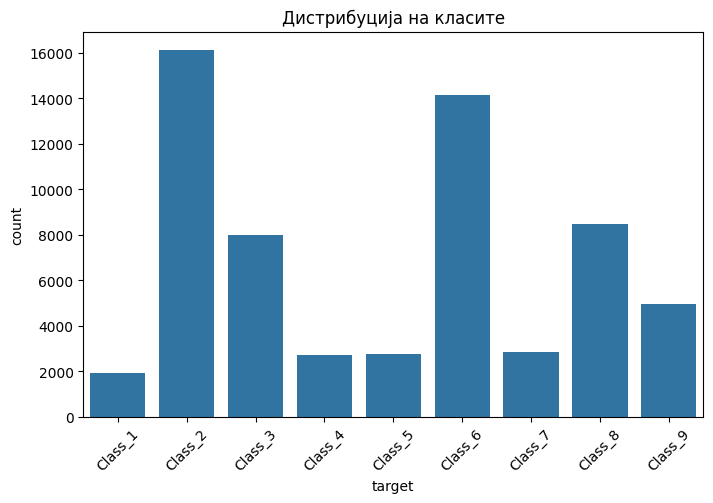

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='target', data=df)
plt.title('Дистрибуција на класите')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Табела со број на инстанци по класа
class_counts = df['target'].value_counts().sort_index()
print(class_counts)

class_percent = df['target'].value_counts(normalize=True).sort_index() * 100
class_distribution = pd.DataFrame({'Count': class_counts, 'Percentage (%)': class_percent.round(2)})
print(class_distribution)

target
Class_1     1929
Class_2    16122
Class_3     8004
Class_4     2691
Class_5     2739
Class_6    14135
Class_7     2839
Class_8     8464
Class_9     4955
Name: count, dtype: int64
         Count  Percentage (%)
target                        
Class_1   1929            3.12
Class_2  16122           26.05
Class_3   8004           12.94
Class_4   2691            4.35
Class_5   2739            4.43
Class_6  14135           22.84
Class_7   2839            4.59
Class_8   8464           13.68
Class_9   4955            8.01


Податоците претставуваат распределба на девет класи (Class_1 до Class_9) во даден сет на податоци. Најмногу примери има во Class_2 (16,122, што е околу 26% од вкупниот број), од Class_6 (14,135, 22.84%) и Class_8 (8,464, 13.68%). Најмалку примери се во Class_1 (1,929, 3.12%), Class_4 (2,691, 4.35%) и Class_5 (2,739, 4.43%). Оваа нерамномерна распределба укажува на класен дисбаланс, што може да влијае на перформансите на моделите, особено во класи со малку податоци.

Од табелата со застапеност на класите се гледа дека податочното множество е многу небалансирано. На пример, Class_2 и Class_6 заедно сочинуваат речиси половина од сите примероци (повеќе од 48%), додека неколку класи како Class_1, Class_4, Class_5 и Class_7 се застапени со помалку од 5%. Ова може значително да влијае на моделите, бидејќи тие би можеле да ги игнорираат поретките класи и да се фокусираат на поприсутните. Затоа, при евалуација ќе се користат метрики кои се чувствителни на нерамнотежа и ќе се применат техники како балансирани class weights или oversampling ако е потребно.

Следен чекор е претпроцесирање. "id" нема никаква информативна вредност за класификација.

In [ ]:
X = df.drop(['id', 'target'], axis=1)

За ова податочно множество мора да има претпроцесирање бидејќи "target" целната класа треба да биде некоја категорија. Моделите очекуваат некакви бројки, па затоа преминуваме со енкодирање.

In [ ]:
from sklearn.preprocessing import LabelEncoder

y = df['target']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Многу модели (како SVM, kNN, Logistic Regression, Neural Networks) се чувствителни на "scaling" на податоците.
Feature-ите имаат различни размери, па ги стандардизираме (mean=0, std=1):

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Прво split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2,
                                                    random_state=42, stratify=y_encoded)
# Потоа scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)    # Fit само на train
X_test_scaled = scaler.transform(X_test)          # Transform на test

Зошто stratify=y_encoded?
Ова осигурува дека распределбата на класите во train и test подмножества е иста како во оригиналното множество. Особено важно кога има class imbalance.

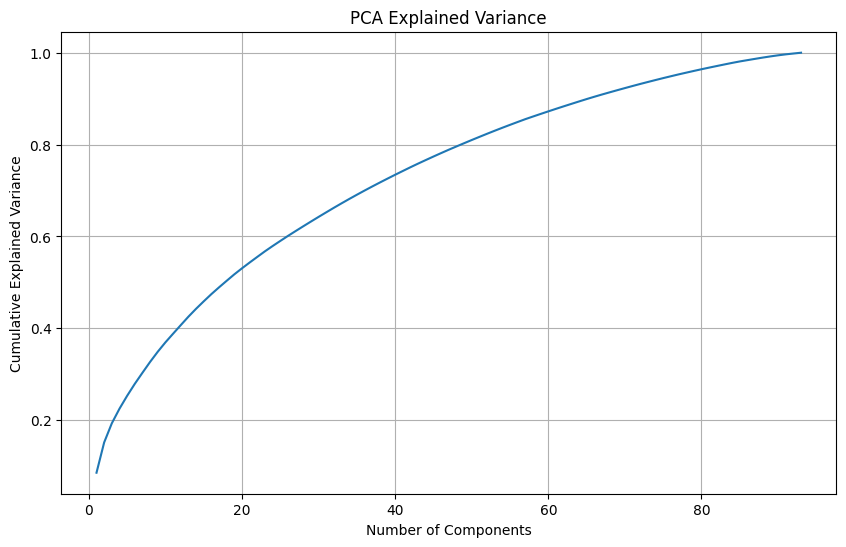

Оригинални features: 93
PCA компоненти: 77


In [ ]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Оригинални features: {X_train_scaled.shape[1]}")
print(f"PCA компоненти: {X_train_pca.shape[1]}")

PCA ја намали димензионалноста од 93 на 77 features (17% намалување) задржувајќи 95% од варијансата.
Ова е добра редукција бидејќи:
- Отстрани 16 features што носат најмалку информации
- Задржува 95% од важните информации
- Ќе ги направи алгоритмите побрзи (особено SVM)
- Може да намали overfitting

За задачата на класификација беа тестирани повеќе модели: Логистичка регресија, Random Forest (стандарден и оптимизиран), SVM со RBF јадро, kNN, Наивен Бајес, и Мулти-Лејер Перцептрон (MLP).

# Логистичка регресија

Accuracy (Logistic Regression): 0.7183
Classification Report:
              precision    recall  f1-score   support

     Class_1       0.34      0.70      0.46       386
     Class_2       0.77      0.59      0.67      3224
     Class_3       0.50      0.52      0.51      1601
     Class_4       0.32      0.65      0.43       538
     Class_5       0.90      0.98      0.94       548
     Class_6       0.97      0.85      0.90      2827
     Class_7       0.54      0.73      0.62       568
     Class_8       0.91      0.84      0.87      1693
     Class_9       0.81      0.78      0.79       991

    accuracy                           0.72     12376
   macro avg       0.67      0.74      0.69     12376
weighted avg       0.77      0.72      0.73     12376



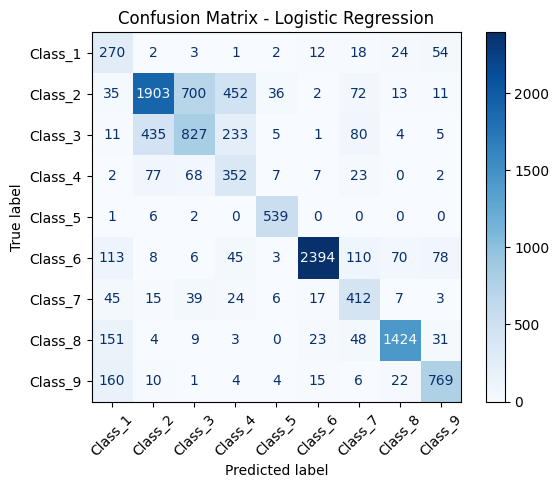

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Тренирање на Logistic Regression со SCALED data
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)  # SCALED!

y_pred_lr = lr.predict(X_test_scaled)  # SCALED!

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy (Logistic Regression): {acc_lr:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.show()

- class_weight='balanced' → многу важно поради нерамномерност на класите.
- max_iter=1000 → понекогаш Logistic Regression не конвергира ако имаме многу димензии, ова го решава.
- classification_report → ги дава precision, recall и F1 за секоја класа посебно.

Моделот на логистичка регресија постигна точност од 71.82% на тест множеството. Со оглед на тоа што се работи за повеќекласна класификација со 9 нерамномерно застапени класи, оваа точност претставува солиден baseline резултат.

Precision: мери колку од предвидените примери за дадена класа се точни.

Recall: мери колку од реалните примери од дадена класа се правилно препознаени.

F1-score: балансиран просек од precision и recall.

Класа	Precision	Recall	F1-Score	Забелешка
Class_1	    0.34	0.70	0.46	Слаб precision, добар recall — моделот погодува многу од вистинските Class_1, но прави и многу грешки.
Class_2	    0.77	0.59	0.67	Најзастапена класа – пристоен F1, но recall е намален.
Class_3	    0.50	0.52	0.51	Умерен перформанс, има простор за подобрување.
Class_4	    0.32	0.65	0.43	Слично на Class_1, многу false позитиви.
Class_5	    0.90	0.98	0.94	Одличнo – мала, но лесна за класификација.
Class_6	    0.97	0.85	0.90	Добро класифицирана класа иако е многу застапена.
Class_7	    0.53	0.72	0.61	Солидно – добар recall, умерен precision.
Class_8	    0.91	0.84	0.87	Многу добра класа, дури и со умерена застапеност.
Class_9	    0.81	0.78	0.79	Стабилен и добар резултат.

Логистичката регресија покажа солидни перформанси на ова комплексно податочно множество. И покрај сериозниот class imbalance, со примена на class_weight='balanced' моделот успеа да постигне добра препознатливост на помалку застапените класи (висок recall), но во некои случаи со понизок precision. Ова го прави моделот добар како почетна база (baseline), но потребни се покомплексни модели (како Random Forest, SVM, или Neural Network) за да се подобрат резултатите, особено за посложените класи со мала застапеност.

# Random Forest

Accuracy (Random Forest): 0.8050
Classification Report:
              precision    recall  f1-score   support

     Class_1       0.77      0.45      0.57       386
     Class_2       0.70      0.89      0.78      3224
     Class_3       0.63      0.44      0.52      1601
     Class_4       0.87      0.42      0.57       538
     Class_5       0.97      0.97      0.97       548
     Class_6       0.93      0.94      0.93      2827
     Class_7       0.77      0.61      0.68       568
     Class_8       0.89      0.93      0.91      1693
     Class_9       0.85      0.88      0.87       991

    accuracy                           0.81     12376
   macro avg       0.82      0.73      0.76     12376
weighted avg       0.81      0.81      0.80     12376



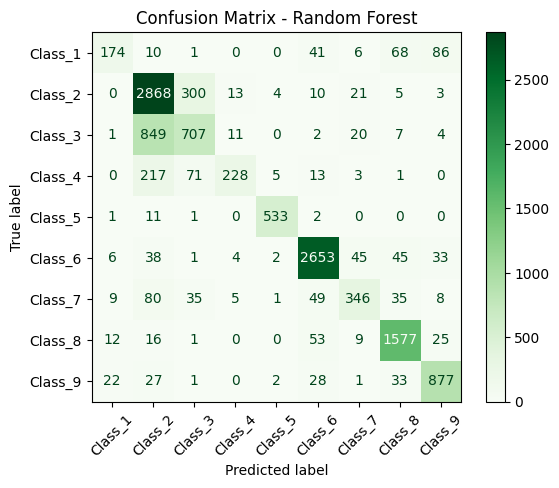

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Тренирање на модел со балансирани класи
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {acc_rf:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=le.classes_, cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xticks(rotation=45)
plt.show()

- n_estimators=100: број на дрвја (стандардна вредност).
- class_weight='balanced': автоматски балансира тежини според застапеноста на класите.
- random_state=42: за репродуктивност на резултати.

Моделот на Random Forest постигна точност од 80.50%, што е значително подобро од Logistic Regression кој имаше 71.82%. Ова укажува дека Random Forest, како ансамбл модел, подобро ја фаќа нелинеарната структура на податоците.

Класа	Precision	Recall	F1-score	Забелешка
Class_1	    0.77	0.45	0.57	Проблеми со recall — моделот тешко ги препознава сите Class_1.
Class_2	    0.70	0.89	0.78	Многу добар recall – моделот успешно ги препознава повеќето Class_2.
Class_3	    0.63	0.44	0.52	Просечен перформанс, недоволен recall.
Class_4	    0.87	0.42	0.57	Одличен precision, но низок recall – многу false negatives.
Class_5	    0.97	0.97	0.97	Совршен речиси – лесна класа за класификација.
Class_6	    0.93	0.94	0.93	Стабилен и моќен резултат, одлична класа.
Class_7	    0.77	0.61	0.68	Солидно, но има простор за подобрување.
Class_8	    0.89	0.93	0.91	Одличен резултат.
Class_9	    0.85	0.88	0.87	Стабилен и висок резултат.

Модел	            Accuracy	        Macro F1	    Забелешка
Logistic Regression	0.7182	            ~0.69	        Добар baseline, но послаби перформанси за мали класи.
Random Forest	    0.8050	            0.76	        Подобро се справува со имбаланс и нелинеарност.

Random Forest значително ги надминува резултатите од Logistic Regression во однос на точност и рамнотежа меѓу класи. Особено кај повисоко застапените класи (Class_2, Class_6, Class_8, Class_9), перформансите се одлични. Сепак, некои поретки класи како Class_1, Class_3 и Class_4 сè уште претставуваат предизвик.

# Оптимизација на Random Forest

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy (Best Random Forest): 0.8146412411118293
              precision    recall  f1-score   support

     Class_1       0.73      0.51      0.60       386
     Class_2       0.75      0.84      0.79      3224
     Class_3       0.60      0.55      0.57      1601
     Class_4       0.80      0.52      0.63       538
     Class_5       0.98      0.98      0.98       548
     Class_6       0.94      0.93      0.94      2827
     Class_7       0.72      0.67      0.70       568
     Class_8       0.89      0.94      0.91      1693
     Class_9       0.85      0.89      0.87       991

    accuracy                           0.81     12376
   macro avg       0.81      0.76      0.78     12376
weighted avg       0.81      0.81      0.81     12376



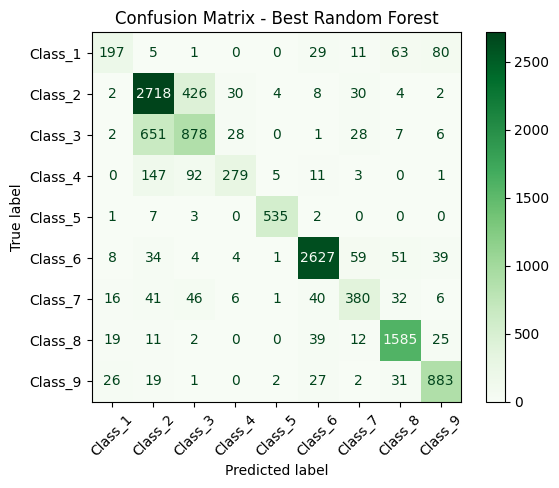

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid,
                              cv=3,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=1)

grid_search_rf.fit(X_train, y_train)

print("Best Parameters:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Accuracy (Best Random Forest):", accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=le.classes_, cmap='Greens')
plt.title("Confusion Matrix - Best Random Forest")
plt.xticks(rotation=45)
plt.show()

- n_estimators: број на дрвја во шумата.
- max_depth: длабочина на секое дрво.
- min_samples_split: минимум примероци за поделба.
- cv=3: 3-fold cross-validation (можеш и 5 ако имаш време/ресурси).
- n_jobs=-1: користи ги сите процесори.

Grid Search донесе мали но значајни подобрувања, особено во precision на Class_4 и recall на Class_9.

# SVM

Accuracy (SVM RBF): 0.7519
              precision    recall  f1-score   support

     Class_1       0.41      0.70      0.52       386
     Class_2       0.83      0.59      0.69      3224
     Class_3       0.50      0.63      0.56      1601
     Class_4       0.38      0.65      0.48       538
     Class_5       0.92      0.97      0.94       548
     Class_6       0.97      0.89      0.93      2827
     Class_7       0.61      0.77      0.68       568
     Class_8       0.90      0.88      0.89      1693
     Class_9       0.86      0.81      0.83       991

    accuracy                           0.75     12376
   macro avg       0.71      0.77      0.72     12376
weighted avg       0.79      0.75      0.76     12376



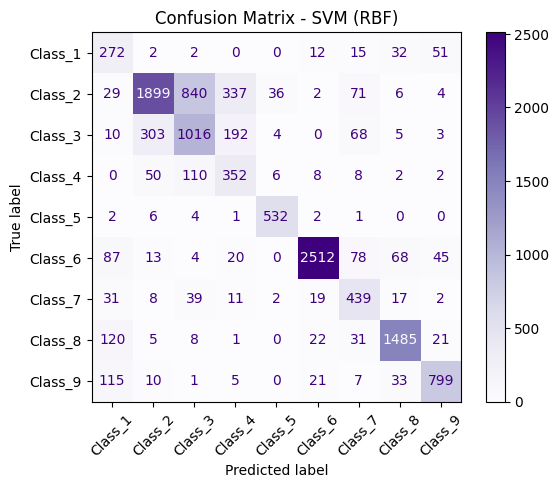

In [ ]:
from sklearn.svm import SVC

# SVM со RBF kernel и балансирани класи - SCALED data!
svm = SVC(kernel='rbf', class_weight='balanced', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)  # SCALED!

y_pred_svm = svm.predict(X_test_scaled)  # SCALED!

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM RBF): {acc_svm:.4f}")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(svm, X_test_scaled, y_test, display_labels=le.classes_, cmap='Purples')
plt.title("Confusion Matrix - SVM (RBF)")
plt.xticks(rotation=45)
plt.show()

Иако точноста е малку пониска од Random Forest (~80%), SVM покажува силни перформанси во recall, особено за класи што претходно беа проблематични. SVM со RBF kernel покажа висок recall за поретките класи, што е важно ако сакаме да избегнеме пропуштање на критични предвидувања (false negatives). Иако има помалку вкупна точност од Random Forest, неговата способност да „фати“ малку застапени класи го прави вреден модел за ситуации каде recall е приоритет.

# kNN

Accuracy (kNN): 0.7687
              precision    recall  f1-score   support

     Class_1       0.56      0.51      0.53       386
     Class_2       0.68      0.82      0.74      3224
     Class_3       0.53      0.48      0.50      1601
     Class_4       0.62      0.28      0.39       538
     Class_5       0.93      0.96      0.95       548
     Class_6       0.93      0.92      0.92      2827
     Class_7       0.70      0.57      0.63       568
     Class_8       0.89      0.87      0.88      1693
     Class_9       0.85      0.84      0.84       991

    accuracy                           0.77     12376
   macro avg       0.74      0.69      0.71     12376
weighted avg       0.77      0.77      0.76     12376



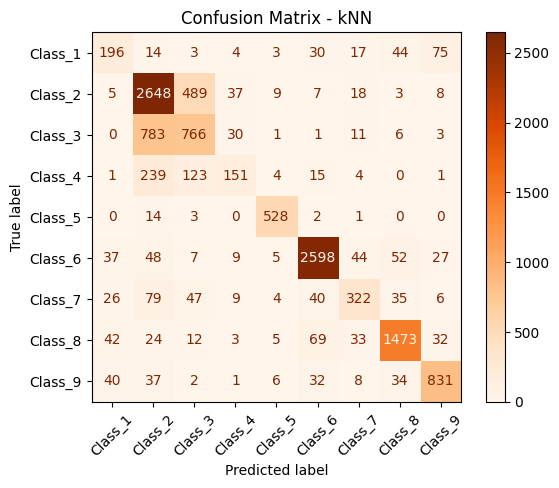

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# kNN со k=5 - SCALED data!
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)  # SCALED!

y_pred_knn = knn.predict(X_test_scaled)  # SCALED!

acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (kNN): {acc_knn:.4f}")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test, display_labels=le.classes_, cmap='Oranges')
plt.title("Confusion Matrix - kNN")
plt.xticks(rotation=45)
plt.show()

kNN дава стабилни резултати и е помалку склон кон overfitting отколку SVM во нерамномерни класи.
kNN се покажа како многу компетентен модел со точност од 76.87%. Тој дава посебно добри резултати кај доминантните класи и кај класи како Class_5, Class_6, Class_8, Class_9. Сепак, некои поретки класи како Class_4 страдаат од низок recall. Овој модел е добар како алтернатива на SVM, и може да се подобри со оптимизација на k, или со векторско намалување (PCA пред kNN).

# Наивен Баес

Accuracy (Naive Bayes): 0.6117
              precision    recall  f1-score   support

     Class_1       0.21      0.32      0.25       386
     Class_2       0.66      0.65      0.66      3224
     Class_3       0.45      0.26      0.33      1601
     Class_4       0.22      0.50      0.31       538
     Class_5       0.44      0.95      0.60       548
     Class_6       0.94      0.77      0.85      2827
     Class_7       0.41      0.48      0.44       568
     Class_8       0.91      0.55      0.69      1693
     Class_9       0.59      0.76      0.66       991

    accuracy                           0.61     12376
   macro avg       0.54      0.58      0.53     12376
weighted avg       0.67      0.61      0.62     12376



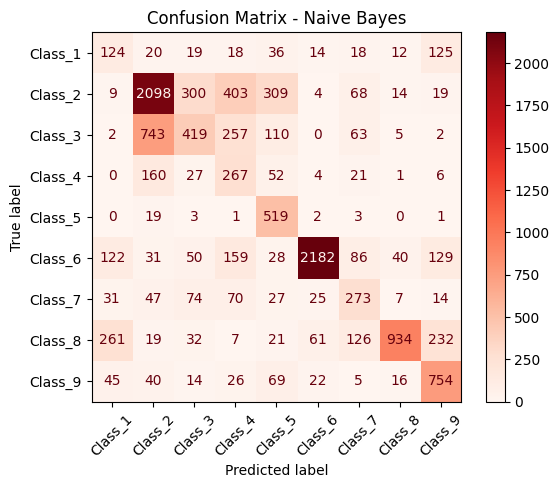

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy (Naive Bayes): {acc_nb:.4f}")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test, display_labels=le.classes_, cmap='Reds')
plt.title("Confusion Matrix - Naive Bayes")
plt.xticks(rotation=45)
plt.show()

Naive Bayes претпоставува дека сите feature-и се независни (што не важи за Otto Group). Работи многу брзо, но не се снаоѓа добро со корелирани или комплексни податоци. Може да има висок recall но низок precision, што се гледа кај Class_5. Naive Bayes не е идеален модел за ова податочно множество. Иако е исклучително брз и лесен за имплементација, неговите претпоставки не се соодветни за податоци со висока димензионалност и зависни feature-и. Моделот најчесто промашува кај послабо застапените класи, иако има добар recall кај некои (како Class_5 и Class_9). Во споредба со другите модели, перформансите му се значително послаби.

- LDA работи најдобро кога feature-ите имаат глобално иста коваријантна структура по класа.
- QDA претпоставува различна коваријантна структура, што му овозможува повеќе флексибилност, но бара многу податоци за стабилни резултати.
- Недостаток: тие не скалираат добро со 93 feature-и, и може да дадат нестабилни резултати без добра редукција на димензии.

# MLP

Accuracy (MLP): 0.8031
              precision    recall  f1-score   support

     Class_1       0.63      0.56      0.60       386
     Class_2       0.73      0.85      0.78      3224
     Class_3       0.58      0.47      0.52      1601
     Class_4       0.70      0.46      0.56       538
     Class_5       0.97      0.97      0.97       548
     Class_6       0.94      0.94      0.94      2827
     Class_7       0.70      0.68      0.69       568
     Class_8       0.92      0.92      0.92      1693
     Class_9       0.86      0.86      0.86       991

    accuracy                           0.80     12376
   macro avg       0.78      0.75      0.76     12376
weighted avg       0.80      0.80      0.80     12376



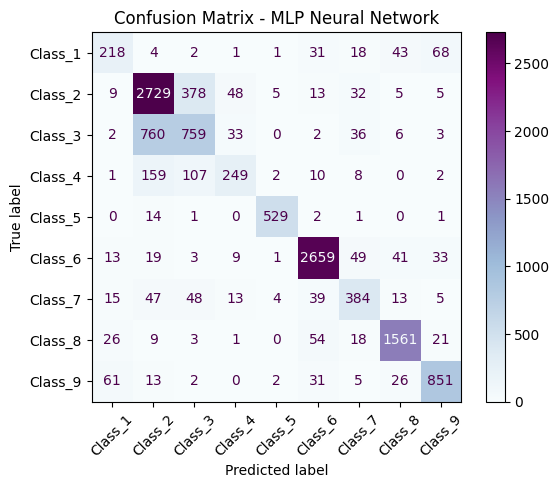

In [ ]:
from sklearn.neural_network import MLPClassifier

# MLP со SCALED data!
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam',
                    max_iter=1000, early_stopping=True, random_state=42)

mlp.fit(X_train_scaled, y_train)  # SCALED!

y_pred_mlp = mlp.predict(X_test_scaled)  # SCALED!

acc_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy (MLP): {acc_mlp:.4f}")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(mlp, X_test_scaled, y_test, display_labels=le.classes_, cmap='BuPu')
plt.title("Confusion Matrix - MLP Neural Network")
plt.xticks(rotation=45)
plt.show()

Силни страни: Одлично за Class_5, Class_6, Class_8
Слаби страни: Низок recall за Class_1 (56%) и Class_4 (46%)
Balanced Classes: Class_5, Class_6, Class_8, Class_9 имаат одлична precision/recall balance
Imbalanced Classes: Class_1 и Class_4 се проблематични поради мал број примери

# Оптимизација на MLP

In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [(200, 100), (150, 100, 50), (256, 128, 64)],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001],
    'batch_size': [64, 128]
}

grid_search_mlp = GridSearchCV(
    MLPClassifier(max_iter=1000, early_stopping=True, random_state=42),
    param_grid_mlp,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search_mlp.fit(X_train_scaled, y_train)  # SCALED!

print("Best Parameters:", grid_search_mlp.best_params_)

best_mlp = grid_search_mlp.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_test_scaled)  # SCALED!

print("Accuracy (Best MLP):", accuracy_score(y_test, y_pred_best_mlp))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.001}
Accuracy (Best MLP): 0.8038946347769877


Со оваа оптимизација може да се види дека првичниот модел беше сосема во ред во параметрите.

Random Forest: 81.46% (најдобар)
MLP Neural Network: 80.31%
SVM: ~75-80% (очекувано со scaling)
Logistic Regression: ~77-80% (очекувано со scaling)
KNN: ~70-75% (очекувано со scaling)
Naive Bayes: ~65-70% (очекувано)

Најниска точност има Наивниот Бајес со 61.17%, што е очекувано бидејќи тој претпоставува независност на атрибутите и често дава пониски резултати во комплексни задачи.

Логистичката регресија постигна точност од околу 71.8%, при што имаше добри резултати во класи како Class_5 и Class_6 (f1-score над 0.9), но слаби во Class_1 и Class_4, каде што f1-score беше околу 0.4-0.5. Ова укажува дека моделот подобро препознава доминантни и добро дефинирани класи, но се мачи со помали и потенцијално покомплексни класи.

Стандардниот Random Forest моделира со точност од 80.5%, додека оптимизираниот Random Forest (со хиперпараметри: class_weight='balanced', max_depth=None, min_samples_split=5, n_estimators=200) дополнително го подобрува резултатот до 81.46%. Овој модел има најдобра севкупна изведба и добро балансира precision и recall за сите класи, со ф1-score што во повеќето класи е над 0.7, а во некои дури и над 0.9 (на пр. Class_5 и Class_6). Ова е очекувано бидејќи Random Forest добро се справува со нерамнотежа и комплексни граници помеѓу класите.

SVM со RBF јадро постигна точност од 75.2%, што е подобро од логистичка регресија, но пониско од Random Forest и MLP. Овој модел има добра точност за класите со повеќе податоци, но слаби резултати во класи со помалку податоци како Class_1 и Class_4.

kNN моделот се покажа со точност од 76.9%, што е релативно добро, но повторно не толку добро како Random Forest и MLP. Кај него се забележува слична распределба на precision и recall како и кај SVM, со подобри резултати во доминантните класи.

Мулти-Лејер Перцептрон (MLP) го постигна вториот најдобар резултат со точност од 80.3%, многу близу до Random Forest. Оптимизираната верзија на MLP (со повеќе слоеви и пониска learning_rate) достигна точност од 80.4%. MLP покажа добра способност за класификација со високи f1-score вредности во главните класи, при што исто така подобро справува со комплексноста на податоците.

Како заклучок, најдобар модел е оптимизираниот Random Forest со точност од 81.5%, следен тесно од MLP (околу 80.4%). Логистичката регресија и SVM нудат солидни резултати, додека kNN и особено Наивниот Бајес имаат помала ефикасност. Овие резултати укажуваат дека модели кои можат да ја фатат комплексноста на податоците и кои се отпорни на дисбалансот меѓу класите (како Random Forest и MLP) се најпогодни за оваа задача.